In [2]:
pip install mlflow


   ---------------------------------------- 0.0/28.4 MB ? eta -:--:--
   ---------------------------------------- 0.2/28.4 MB 4.8 MB/s eta 0:00:06
    --------------------------------------- 0.6/28.4 MB 5.9 MB/s eta 0:00:05
   - -------------------------------------- 0.9/28.4 MB 6.6 MB/s eta 0:00:05
   - -------------------------------------- 1.2/28.4 MB 6.5 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/28.4 MB 6.8 MB/s eta 0:00:04
   -- ------------------------------------- 1.9/28.4 MB 6.8 MB/s eta 0:00:04
   --- ------------------------------------ 2.1/28.4 MB 6.8 MB/s eta 0:00:04
   --- ------------------------------------ 2.4/28.4 MB 6.4 MB/s eta 0:00:05
   --- ------------------------------------ 2.8/28.4 MB 6.8 MB/s eta 0:00:04
   ---- ----------------------------------- 3.2/28.4 MB 6.9 MB/s eta 0:00:04
   ---- ----------------------------------- 3.5/28.4 MB 6.9 MB/s eta 0:00:04
   ----- ---------------------------------- 3.8/28.4 MB 6.9 MB/s eta 0:00:04
   ---

In [5]:

#Step 1: Setup Environment and Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

# For text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\HEEMA
[nltk_data]     SAMEERA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
#Step 1: Setup Environment and Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

# For text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# For machine learning and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)

# For baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# For oversampling to handle class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# For MLflow logging
import mlflow
import mlflow.tensorflow
import tempfile

[nltk_data] Downloading package stopwords to C:\Users\HEEMA
[nltk_data]     SAMEERA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Set seed for reproducibility
SEED = 22
np.random.seed(SEED)
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

In [9]:
# Load the SMS Spam Collection Dataset
df = pd.read_csv(r"C:\Users\HEEMA SAMEERA\Downloads\archive (1)\spam.csv", encoding="latin-1")

df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df['label'] = df['label'].map({'ham': 0, 'spam': 1})


In [10]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("First 5 rows:")
print(df.head())


Dataset shape: (5572, 2)
First 5 rows:
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


In [11]:
# Check for missing values and duplicate rows
print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# Analyze class distribution to identify imbalances
print("Class distribution:")
print(df['label'].value_counts())

Missing values:
 label      0
message    0
dtype: int64
Duplicate rows: 403
Class distribution:
label
0    4825
1     747
Name: count, dtype: int64


In [12]:
#Step 3: Data Preprocessing and Train-Test Split
# Define a seed for reproducibility
SEED = 42  

def clean_text(text):
    """
    Clean the input text by converting to a string (if not already),
    lowering the case, removing non-alphabetical characters,
    and ensuring messages are not completely removed.
    """
    if not isinstance(text, str):
        text = str(text) if pd.notnull(text) else ""  # Convert non-string values to string
    text = text.lower()
    
    # Allow numbers to prevent complete removal of numeric messages
    text = re.sub(r'[^a-z0-9\s]', '', text)  

    return text.strip() if text.strip() else "empty"  # Replace empty strings with a placeholder

# Apply text cleaning
df['clean_message'] = df['message'].apply(clean_text)


In [13]:
# Split the dataset into training and testing sets (Stratified to maintain label distribution)
X = df['clean_message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)


In [14]:

# Check class distribution before filtering
print("Class distribution before filtering:\n", y_train.value_counts())

Class distribution before filtering:
 label
0    3859
1     598
Name: count, dtype: int64


In [15]:

# Ensure empty messages are replaced instead of removed
X_train = X_train.apply(lambda x: "empty" if x.strip() == "" else x)

In [16]:
# Reset indices to keep alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [17]:
# Check class distribution after filtering
print("Class distribution after filtering:\n", y_train.value_counts())


Class distribution after filtering:
 label
0    3859
1     598
Name: count, dtype: int64


In [18]:
# Verify that both classes are still present
if y_train.nunique() == 1:
    print("Error: Only one class remains after filtering. Adjust cleaning logic.")


In [19]:
#Step 4: Baseline Model using Naive Bayes & Logistic Regression
#Step 4.1: Baseline Model using Naive Bayes
# Convert text to TF-IDF features, fitting on the training set only to avoid data leakage
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=SEED)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)



In [20]:
# Train a naive bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train_bal, y_train_bal)

# Predict on the test set
y_pred_NB = NB_model.predict(X_test_tfidf)

# Evaluate the baseline model with various metrics
print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_NB))
print("Precision:", precision_score(y_test, y_pred_NB))
print("Recall:", recall_score(y_test, y_pred_NB))
print("F1 Score:", f1_score(y_test, y_pred_NB))
print("Classification Report:\n", classification_report(y_test, y_pred_NB))

Naive Bayes Performance:
Accuracy: 0.9757847533632287
Precision: 0.9121621621621622
Recall: 0.9060402684563759
F1 Score: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.91      0.91       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



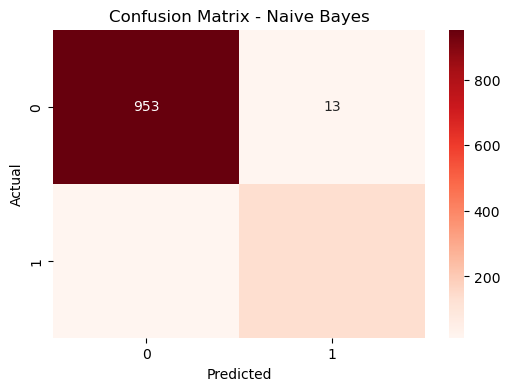

In [21]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_NB)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
#Step 4.2: Baseline Model using Logistic Regression
# Train a logistic regression model
log_reg = LogisticRegression(random_state=SEED, max_iter=500)
log_reg.fit(X_train_bal, y_train_bal)

# Predict on the test set
y_pred_lr = log_reg.predict(X_test_tfidf)

# Evaluate the baseline model with various metrics
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Performance:
Accuracy: 0.979372197309417
Precision: 0.9315068493150684
Recall: 0.912751677852349
F1 Score: 0.9220338983050848
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.91      0.92       149

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



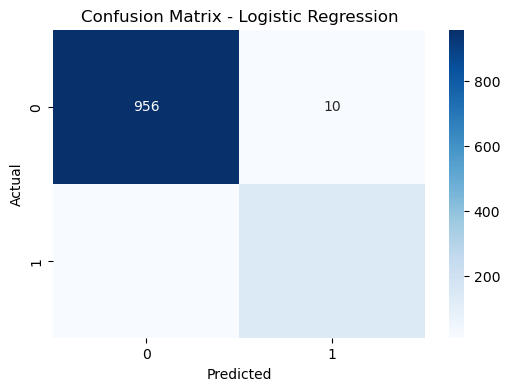

In [23]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
